In [1]:
%load_ext cython
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit


from scipy import stats
from scipy.optimize import curve_fit

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    return temp3


@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2


@np.vectorize
def correct_W(e_p, theta, A, B, C, D, E, F):
    return A*calc_W(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

@np.vectorize
def correct_Q2(e_p, theta, A, B, C, D, E, F):
    return A*calc_q2(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

@cython.embedsignature(True)
def FitWHist(X, A, B, C, D, E, F):
    e_p, theta = X
    w_new = correct_W(e_p, theta, A, B, C, D, E, F)
    w_new = w_new[np.isfinite(w_new)]
    mu, std = stats.norm.fit(w_new)
    return np.sqrt((mu-MP)**2 + (std)**2) 

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



def FitFunc(phi_e, theta_e, 
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D, Bt):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
 

In [4]:
df = pd.read_csv("mom_corr_elastic.dat")

df = df[(df.W_uncorr > 0.85) & (df.W_uncorr < 1.2)]
df['e_theta'] = np.deg2rad(df.e_theta)
df['e_phi_center'] = np.deg2rad(center_phi(df.e_phi, df.sector))
df['e_phi'] = np.deg2rad(df.e_phi)
df['p_theta'] = np.deg2rad(df.p_theta)
df['p_phi'] = np.deg2rad(df.p_phi)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']
%time df['w_corr'] = calc_W(df.e_p.to_numpy(), df.e_theta.to_numpy(), df.e_phi.to_numpy())
%time df['q2_corr'] = calc_q2(df.e_p.to_numpy(), df.e_theta.to_numpy(), df.e_phi.to_numpy())
df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)
#df = df[np.abs(df.delta_theta) < 0.005]




CPU times: user 40.7 ms, sys: 20.9 ms, total: 61.7 ms
Wall time: 61.8 ms
CPU times: user 43.6 ms, sys: 15.1 ms, total: 58.7 ms
Wall time: 58.4 ms


In [5]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,w_corr,q2_corr,p_p_calc
0,3.867114,0.302877,-0.630023,1.606884,0.822251,2.523154,0.983592,1.695892,3,-0.106424,0.300571,-0.002306,0.983591,1.695893,0.968364
2,3.823474,0.320880,1.468849,1.707246,0.789636,-1.651257,0.930052,1.880240,1,-0.101948,0.320518,-0.000362,0.930053,1.880239,0.912973
4,3.808950,0.320004,2.788525,1.675734,0.789702,-0.359243,0.953690,1.862967,6,0.170531,0.320476,0.000472,0.953689,1.862969,0.913083
5,4.044248,0.268281,-1.527046,1.388920,0.881333,1.606775,0.968046,1.393833,4,0.043751,0.267199,-0.001082,0.968044,1.393835,1.074239
6,3.907971,0.292540,1.706743,1.572335,0.835882,-1.425245,0.993494,1.599645,1,0.135946,0.292574,0.000033,0.993494,1.599645,0.992134


In [6]:
# p0 = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
# popt, pcov = curve_fit(FitWHist, (df.e_p.to_numpy(), df.e_theta.to_numpy()), np.zeros_like(df.e_p), p0=p0, maxfev=8000)
# print(*popt)

In [7]:
# df['w_corr'] = correct_W(df.e_p, df.e_theta, *popt)
# df['q2_corr'] = correct_Q2(df.e_p, df.e_theta, *popt)

In [8]:
# plt.hist(df.w_corr, bins=500)
# plt.axvline(MP)
# plt.hist(df.W_uncorr, bins=500, alpha=0.2)
# plt.show()

In [9]:
# plt.hist(df.w_corr-df.W_uncorr, bins=500)
# plt.show()

In [10]:
# plt.hist2d(df.w_corr, df.q2_corr, bins=500, range=[[0.8,1.2],None])
# plt.axvline(MP)
# plt.show()

# plt.hist2d(df.W_uncorr, df.Q2_uncorr, bins=500, range=[[0.8,1.2],None])
# plt.axvline(MP)
# plt.show()

In [11]:
from lmfit import Model, Parameters, Parameter

def _FitWHist(X, A, B, C, D, E, F):
    return FitWHist(X, A, B, C, D, E, F)

model = Model(_FitWHist)
params = Parameters()

params['A'] = Parameter(name='A', value=1.0, min=0.98, max=1.2)
params['B'] = Parameter(name='B', value=1.0, min=0.98, max=1.2)
params['C'] = Parameter(name='C', value=1.0, min=0.98, max=1.2)

params['D'] = Parameter(name='D', value=0.0, min=-0.5, max=0.5)
params['E'] = Parameter(name='E', value=0.0, min=-0.5, max=0.5)
params['F'] = Parameter(name='F', value=0.0, min=-0.5, max=0.5)


print('parameter names: {}'.format(model.param_names))
print('independent variables: {}'.format(model.independent_vars))

parameter names: ['A', 'B', 'C', 'D', 'E', 'F']
independent variables: ['X']


In [12]:
result = model.fit(np.zeros_like(df.e_p), params, 
                   X=(df.e_p.to_numpy(), df.e_theta.to_numpy()),
                   method='Nelder')

KeyboardInterrupt: 

In [ ]:
print(*result.best_values.values())

In [ ]:
%time df['w_corr'] = correct_W(df.e_p, df.e_theta, *popt)
%time df['q2_corr'] = correct_Q2(df.e_p, df.e_theta, *popt)

%time df['w_corr_lmfit'] = correct_W(df.e_p, df.e_theta, *result.best_values.values())
%time df['q2_corr_lmfit'] = correct_Q2(df.e_p, df.e_theta, *result.best_values.values())

plt.hist(df.w_corr, bins=500,alpha=0.2)
plt.hist(df.w_corr_lmfit, bins=500,alpha=0.2)
plt.hist(df.W_uncorr, bins=500, alpha=0.2)
plt.show()

In [ ]:
plt.hist2d(df.w_corr, df.q2_corr, bins=500, range=[[0.8,1.2],[0,3]])
plt.axvline(MP)
plt.show()

plt.hist2d(df.w_corr_lmfit, df.q2_corr_lmfit, bins=500, range=[[0.8,1.2],[0,3]])
plt.axvline(MP)
plt.show()

plt.hist2d(df.W_uncorr, df.Q2_uncorr, bins=500, range=[[0.8,1.2],[0,3]])
plt.axvline(MP)
plt.show()

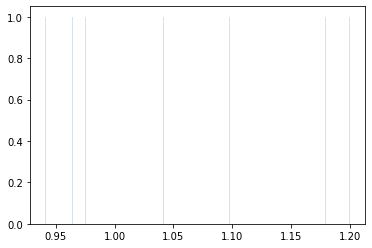

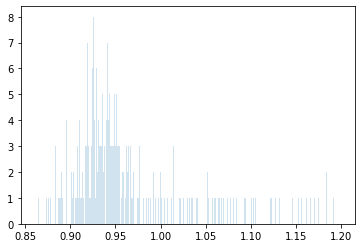

KeyboardInterrupt: 

In [14]:
for sec in range(1,6):
    for momentum in np.arange(1.5, 4.0, 0.5):
        data = df[(df.sector == sec) & (df.e_p >= momentum) & (df.e_p < momentum+0.5)].copy()
        if len(data) > 500:
            model = Model(_FitWHist)
            params = Parameters()

            params['A'] = Parameter(name='A', value=1.0, min=0.98, max=1.2)
            params['B'] = Parameter(name='B', value=1.0, min=0.98, max=1.2)
            params['C'] = Parameter(name='C', value=1.0, min=0.98, max=1.2)

            params['D'] = Parameter(name='D', value=0.0, min=-0.5, max=0.5)
            params['E'] = Parameter(name='E', value=0.0, min=-0.5, max=0.5)
            params['F'] = Parameter(name='F', value=0.0, min=-0.5, max=0.5)

            result = model.fit(np.zeros_like(df.e_p), params, 
                       X=(df.e_p.to_numpy(), df.e_theta.to_numpy()))

            data['w_corr_lmfit'] = correct_W(data.e_p, data.e_theta, *result.best_values.values())
            data['q2_corr_lmfit'] = correct_Q2(data.e_p, data.e_theta, *result.best_values.values())

            plt.hist(data.w_corr_lmfit, bins=500,alpha=0.2)
        plt.hist(data.W_uncorr, bins=500, alpha=0.2)
        plt.show()